In [9]:
%load_ext autoreload
%autoreload 2
from boxes import *
from learner import *
import math
import matplotlib.pyplot as plt
import os
import wandb
import pickle

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu
    torch.cuda.manual_seed_all(seed)  # gpu
    
set_seed(42)

torch.set_printoptions(precision=16)

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
use_cuda

False

In [12]:
PATH = '../data/ontologies/anatomy/'

# aligment training split
ats = 0.8

# Transitive closure
Transitive_Closure = False

if Transitive_Closure:
    tc = "tc_"
else:
    tc = ""

# Data in unary.tsv are probabilites separated by newlines. The probability on line n is P(n), where n is the id assigned to the nth element.
unary_prob = torch.from_numpy(np.loadtxt(f'{PATH}unary/unary.tsv')).float().to(device)
num_boxes = unary_prob.shape[0]

# We're going to use random negative sampling during training, so no need to include negatives in our training data itself
train = Probs.load_from_julia(PATH, f'tr_pos_{tc}{ats}.tsv', f'tr_neg_{ats}.tsv', ratio_neg = 0).to(device)

# The dev set will have a fixed set of negatives, however.
dev = Probs.load_from_julia(PATH, f'dev_align_pos_{ats}.tsv', f'dev_align_neg_{ats}.tsv', ratio_neg = 1).to(device)

# This set is used just for evaluation purposes after training
tr_align = Probs.load_from_julia(PATH, f'tr_align_pos_{ats}.tsv', f'tr_align_neg_{ats}.tsv', ratio_neg = 1).to(device)


In [13]:
with open('../data/ontologies/anatomy/human.pickle', 'rb') as f:
    human_pickle = pickle.load(f)
    
with open('../data/ontologies/anatomy/mouse.pickle', 'rb') as f:
    mouse_pickle = pickle.load(f)
    
with open('../data/ontologies/anatomy/entities.pickle', 'rb') as f:
    entity_pickle = pickle.load(f)

In [40]:
curr_entity = 1

sibling_num = np.zeros(3000)

def find_depth(curr_entity):  
    if curr_entity in mouse_pickle['children_of']:
        
        for child in mouse_pickle['children_of'][curr_entity]:
            sibling_num[child] = len(mouse_pickle['children_of'][curr_entity])
            if sibling_num[child] <=3:
                if child in mouse_pickle['parents_of'].keys():
                    parent = mouse_pickle['parents_of'][child][0]
                    if sibling_num[parent] <= 3:
                        if parent in mouse_pickle['parents_of'].keys():
                            grandparent = mouse_pickle['parents_of'][parent][0]
                            if sibling_num[grandparent] <= 3:
                                print(child, parent, grandparent)
                                print(sibling_num[child], sibling_num[parent], sibling_num[grandparent])
                                print()
            find_depth(child)
            
find_depth(curr_entity)

5 6 1
3.0 1.0 0.0

1848 573 127
2.0 0.0 0.0

772 767 770
2.0 0.0 0.0

773 769 771
2.0 0.0 0.0

776 770 94
1.0 0.0 0.0

779 778 770
3.0 0.0 0.0

781 778 770
1.0 0.0 0.0

76 641 605
3.0 3.0 3.0

84 641 605
3.0 3.0 3.0

779 778 770
3.0 0.0 0.0

2499 641 605
3.0 3.0 3.0

677 665 666
2.0 2.0 2.0

683 665 666
2.0 2.0 2.0

749 745 723
2.0 2.0 2.0

755 745 723
2.0 2.0 2.0

2494 78 73
1.0 3.0 3.0

2496 2494 78
3.0 1.0 3.0

2497 2494 78
3.0 1.0 3.0

2498 2494 78
3.0 1.0 3.0

766 767 770
3.0 3.0 3.0

772 767 770
3.0 3.0 3.0

774 767 770
3.0 3.0 3.0

777 778 770
3.0 3.0 3.0

779 778 770
3.0 3.0 3.0

781 778 770
3.0 3.0 3.0

928 216 214
3.0 2.0 2.0

929 216 214
3.0 2.0 2.0

930 216 214
3.0 2.0 2.0

70 5 6
2.0 3.0 1.0

170 5 6
2.0 3.0 1.0

176 177 172
1.0 1.0 3.0

199 198 197
1.0 3.0 1.0

843 199 198
3.0 1.0 3.0

844 199 198
3.0 1.0 3.0

845 199 198
3.0 1.0 3.0

849 848 847
2.0 1.0 2.0

850 848 847
2.0 1.0 2.0

2491 2488 2487
3.0 0.0 0.0

2490 2487 19
1.0 0.0 2.0

680 671 672
2.0 3.0 2.0

686 671 67

1616 1615 1605
2.0 2.0 3.0

1617 1615 1605
2.0 2.0 3.0

1703 1701 1697
2.0 2.0 3.0

426 138 620
3.0 0.0 0.0

429 426 138
3.0 3.0 0.0

2667 1719 431
2.0 0.0 0.0

1710 426 138
3.0 3.0 0.0

2662 1710 426
2.0 3.0 3.0

2663 1711 432
2.0 0.0 0.0

1711 432 138
3.0 0.0 0.0

2664 1719 431
2.0 0.0 0.0

430 138 620
3.0 0.0 0.0

431 138 620
3.0 0.0 0.0

2667 1719 431
2.0 0.0 3.0

2664 1719 431
2.0 0.0 3.0

432 138 620
2.0 0.0 0.0

426 138 620
3.0 0.0 0.0

429 426 138
3.0 3.0 0.0

1710 426 138
3.0 3.0 0.0

2662 1710 426
2.0 3.0 3.0

1711 432 138
3.0 2.0 0.0

430 138 620
3.0 0.0 0.0

431 138 620
3.0 0.0 0.0

432 138 620
2.0 0.0 0.0

443 138 620
3.0 0.0 0.0

1739 2599 1769
3.0 0.0 0.0

1738 1739 2599
2.0 3.0 0.0

1740 1739 2599
2.0 3.0 0.0

2617 2614 2620
3.0 0.0 0.0

1764 1761 1760
3.0 0.0 0.0

2632 1760 452
3.0 0.0 0.0

2633 2634 2635
3.0 0.0 0.0

1739 2599 1769
3.0 0.0 0.0

1738 1739 2599
2.0 3.0 0.0

1740 1739 2599
2.0 3.0 0.0

2617 2614 2620
3.0 0.0 0.0

2604 2603 2282
2.0 3.0 3.0

2605 2603 228

In [119]:
human_pickle['children_of'][2848]

[2846, 5777]

In [98]:
human_pickle['parents_of'][2845]

[2933, 2935]

In [97]:
entity_pickle['align_dict'][284]

[2845]

In [123]:
entity_pickle['label2idx']['Vasculature']

KeyError: 'Vasculature'

In [121]:
entity_pickle['label2idx']['Skin_of_the_Lip']

2846

In [91]:
human_pickle['children_of'][3653]

[4332, 5585, 5587, 5589, 5632, 5673, 5674, 5675, 5676, 5684]

In [90]:
entity_pickle['idx2label'][5673]

'Vein_Endothelium'

In [56]:
entity_pickle.keys()

dict_keys(['all_edges', 'alignments', 'name2idx', 'idx2name', 'label2idx', 'idx2label', 'set', 'align_dict'])

In [76]:
entity_pickle['align_dict'][770]

[3653]

In [77]:
human_pickle['children_of'][3653]

[4332, 5585, 5587, 5589, 5632, 5673, 5674, 5675, 5676, 5684]

In [78]:
entity_pickle['align_dict'][767]

[5684]

In [79]:
human_pickle['children_of'][5684]

KeyError: 5684

In [80]:
entity_pickle['align_dict'][776]

[4332]

In [81]:
human_pickle['children_of'][4332]

[4331]

In [82]:
entity_pickle['align_dict'][778]

[5676]

In [83]:
human_pickle['children_of'][5676]

KeyError: 5676

In [84]:
entity_pickle['align_dict'][777]

[5673]

In [85]:
entity_pickle['align_dict'][777]

[5673]

In [86]:
human_pickle['parents_of'][5673]

[3653, 3378]

In [ ]:
766 767 770

In [69]:
entity_pickle['idx2label'][770]

'blood vessel endothelium'

In [50]:
print(entity_pickle['idx2label'][581], '\n',entity_pickle['idx2label'][594], '\n', entity_pickle['idx2label'][605])

back blood vessel 
 abdomen/pelvis/perineum blood vessel 
 thorax blood vessel


In [51]:
print(entity_pickle['idx2label'][604], '\n',entity_pickle['idx2label'][635], '\n', entity_pickle['idx2label'][641])

upper back blood vessel 
 chest blood vessel 
 thoracic cavity blood vessel


In [52]:
print(entity_pickle['idx2label'][76], '\n',entity_pickle['idx2label'][84], '\n', entity_pickle['idx2label'][2499])

thoracic cavity artery 
 thoracic cavity vein 
 lung blood vessel


In [14]:
mouse_pickle['children_of'][3]

[2, 251]

In [72]:
mouse_pickle['children_of'][767]

[766, 772, 774]

In [74]:
mouse_pickle['children_of'][776]

KeyError: 776

In [75]:
mouse_pickle['children_of'][778]

[777, 779, 781]

In [6]:
mouse_eval = Probs.load_from_julia(PATH, 'human_dev_pos.tsv', 'human_dev_neg.tsv', ratio_neg = 1).to(device)
human_eval = Probs.load_from_julia(PATH, 'mouse_dev_pos.tsv', 'mouse_dev_neg.tsv', ratio_neg = 1).to(device)

In [7]:
curr_entity = 1

def find_depth(curr_entity):  
    if curr_entity in mouse_pickle['children_of']:
        max_depth = 0
        for child in mouse_pickle['children_of'][curr_entity]:
            tmp_depth = find_depth(child)
            if max_depth < tmp_depth:
                max_depth= tmp_depth
        return max_depth+1
    else:
        return 1
            
find_depth(curr_entity)

17

In [18]:
import torch
from torch import Tensor
from torch.nn import Module, Parameter
import torch.nn.functional as F


################################################
# Box Parametrization Layers
################################################
default_init_min_vol = torch.finfo(torch.float32).tiny



class BoxParam(Module):
    """
    An example class for creating a box parametrization.
    Don't inherit from this, it is just an example which contains the methods for a class to be used as a BoxParam
    layer. Refer to the docstring of the functions when implementing your own BoxParam.

    Note: to avoid naming conflicts with min/max functions, we refer to the min coordinate for a box as `z`, and the
    max coordinate as `Z`.
    """

    def __init__(self, num_models:int, num_boxes:int, dim:int, **kwargs):
        """
        Creates the Parameters used for the representation of boxes.

        :param num_models: Number of models
        :param num_boxes: Number of boxes
        :param dim: Dimension
        :param kwargs: Unused for now, but include this for future possible parameters.
        """
        # Remember to call:
        super().__init__()
        raise NotImplemented


    def forward(self, box_indices = slice(None, None, None), **kwargs) -> Tensor:
        """
        Returns a Tensor representing the boxes specified by `box_indices` in the form they should be used for training.

        :param box_indices: Slice, List, or Tensor of the box indices
        :param kwargs: Unused for now, but include this for future possible parameters.
        :return: Tensor of shape (model, id, zZ, dim).
        """
        raise NotImplemented


class Boxes(Module):
    """
    Parametrize boxes using the min coordinate and max coordinate,
    initialized to be in the unit hypercube.

    self.boxes[model, box, min/max, dim] \in [0,1]

    In this parametrization, the min and max coordinates are explicitly stored
    in separate dimensions (as shown above), which means that care must be
    taken to preserve max > min while training. (See MinBoxSize Callback.)
    """

    def __init__(self, num_models: int, num_boxes: int, dims: int,
                 init_min_vol: float = default_init_min_vol, method = "gibbs", gibbs_iter: int = 2000, **kwargs):
        super().__init__()
        self.boxes = Parameter(initialize_boxes_in_unit_cube((num_models, num_boxes), dims, init_min_vol, method, gibbs_iter, **kwargs))

    def forward(self, box_indices = slice(None, None, None), **kwargs) -> Tensor:
        """
        Returns a Tensor representing the box embeddings specified by box_indices.

        :param box_indices: Slice, List, or Tensor of the box indices
        :param kwargs: Unused for now, but include this for future possible parameters.
        :return: NamedTensor of shape (model, id, zZ, dim).
        """
        return self.boxes[:, box_indices]





class MinMaxSigmoidBoxes(Module):
    """
    Parametrize boxes using sigmoid to make them always valid and contained within the unit cube.

    self.boxes[model, box, 2, dim] in Reals


    In this parametrization, we first convert to the unit cube:

    unit_cube_boxes = torch.sigmoid(self.boxes)  # shape: (model, box, 2, dim)

    We now select the z/Z coordinates by taking the min/max over axis 2, i.e.

    z, _ = torch.min(unit_cube_boxes, dim=2)
    Z, _ = torch.max(unit_cube_boxes, dim=2)
    """

    def __init__(self, num_models: int, num_boxes: int, dim: int, init_min_vol: float = default_init_min_vol,  **kwargs):
        super().__init__()
        unit_boxes = Boxes(num_models, num_boxes, dim, init_min_vol, **kwargs)
        self._from_UnitBoxes(unit_boxes)
        del unit_boxes


    def _from_UnitBoxes(self, unit_boxes:Boxes):
        boxes = unit_boxes().detach().clone()
        self.boxes = Parameter(torch.log(boxes / (1-boxes)))


    def forward(self, box_indices = slice(None, None, None), **kwargs) -> Tensor:
        """
        Returns a Tensor representing the box embeddings specified by box_indices.

        :param box_indices: A NamedTensor of the box indices
        :param kwargs: Unused for now, but include this for future possible parameters.
        :return: Tensor of shape (model, id, zZ, dim).
        """
        unit_cube_boxes = torch.sigmoid(self.boxes)
        z, _ = torch.min(unit_cube_boxes, dim=2)
        Z, _ = torch.max(unit_cube_boxes, dim=2)
        return torch.stack((z,Z), dim=2)


###############################################
# Downstream Model
###############################################

class WeightedSum(Module):
    def __init__(self, num_models: int) -> None:
        super().__init__()
        self.weights = Parameter(torch.rand(num_models))

    def forward(self, box_vols: Tensor) -> Tensor:
        return (F.softmax(self.weights, dim=0).unsqueeze(0) @ box_vols).squeeze()


class LogWeightedSum(Module):
    def __init__(self, num_models: int) -> None:
        super().__init__()
        self.weights = Parameter(torch.rand(num_models))

    def forward(self, log_box_vols: Tensor) -> Tensor:
        return (torch.logsumexp(self.weights + log_box_vols, 0) - torch.logsumexp(self.weights, 0))


class BoxModel(Module):
    def __init__(self, BoxParamType: type, vol_func: Callable,
                 num_models:int, num_boxes:int, dims:int,
                 init_min_vol: float = default_init_min_vol, universe_box: Optional[Callable] = None, **kwargs):
        super().__init__()
        self.box_embedding = BoxParamType(num_models, num_boxes, dims, init_min_vol, **kwargs)
        self.vol_func = vol_func

        if universe_box is None:
            z = torch.zeros(dims)
            Z = torch.ones(dims)
            self.universe_box = lambda _: torch.stack((z,Z))[None, None]
            self.universe_vol = lambda _: self.vol_func(self.universe_box(None)).squeeze()
            self.clamp = True
        else:
            self.universe_box = universe_box
            self.universe_vol = lambda b: self.vol_func(self.universe_box(b))
            self.clamp = False

        self.weights = WeightedSum(num_models)

    def forward(self, box_indices: Tensor) -> Dict:
        # Unary
        box_embeddings_orig = self.box_embedding()
        if self.clamp:
            box_embeddings = box_embeddings_orig.clamp(0,1)
        else:
            box_embeddings = box_embeddings_orig

        universe_vol = self.universe_vol(box_embeddings)

        unary_probs = self.weights(self.vol_func(box_embeddings) / universe_vol)

#         # Conditional
#         A = box_embeddings[:, box_indices[:,0]]
#         B = box_embeddings[:, box_indices[:,1]]
#         A_int_B_vol = self.weights(self.vol_func(intersection(A, B)) / universe_vol) + torch.finfo(torch.float32).tiny
#         B_vol = unary_probs[box_indices[:,1]] + torch.finfo(torch.float32).tiny
#         P_A_given_B = torch.exp(torch.log(A_int_B_vol) - torch.log(B_vol))
        
        # symmetric same
        # print("you are in right place!")
        A = box_embeddings[:, box_indices[:,0]]
        B = box_embeddings[:, box_indices[:,1]]
        A_int_B_vol = self.weights(self.vol_func(intersection(A, B)) / universe_vol) + torch.finfo(torch.float32).tiny
        A_join_B_vol = self.weights(self.vol_func(join(A, B)) / universe_vol) + torch.finfo(torch.float32).tiny
        P_A_given_B = torch.exp(torch.log(A_int_B_vol) - torch.log(A_join_B_vol))

        return {
            "unary_probs": unary_probs,
            "box_embeddings_orig": box_embeddings_orig,
            "A": A,
            "B": B,
            "P(A|B)": P_A_given_B,
        }


class BoxModelStable(Module):
    def __init__(self, BoxParamType: type, log_vol_func: Callable,
                 num_models: int, num_boxes: int, dims: int,
                 init_min_vol: float = default_init_min_vol,
                 universe_box: Optional[Callable] = None, **kwargs):
        super().__init__()
        self.box_embedding = BoxParamType(num_models, num_boxes, dims, init_min_vol, **kwargs)
        self.log_vol_func = log_vol_func

        if universe_box is None:
            z = torch.zeros(dims)
            Z = torch.ones(dims)
            self.universe_box = lambda _: torch.stack((z,Z))[None, None]
            self.log_universe_vol = lambda _: self.log_vol_func(self.universe_box(None)).squeeze()
            self.clamp = True
        else:
            self.universe_box = universe_box
            self.log_universe_vol = lambda b: self.log_vol_func(self.universe_box(b))
            self.clamp = False

        self.weights = LogWeightedSum(num_models)

    def forward(self, box_indices: Tensor) -> Dict:
        # Unary
        box_embeddings_orig = self.box_embedding()
        if self.clamp:
            box_embeddings = box_embeddings_orig.clamp(0,1)
        else:
            box_embeddings = box_embeddings_orig

        log_universe_vol = self.log_universe_vol(box_embeddings)

        log_unary_probs = self.weights(self.log_vol_func(box_embeddings) -  log_universe_vol)

        # Conditional
        A = box_embeddings[:, box_indices[:,0]]
        B = box_embeddings[:, box_indices[:,1]]
        log_A_int_B_vol = self.weights(self.log_vol_func(intersection(A, B)) - log_universe_vol)
        log_B_vol = log_unary_probs[box_indices[:,1]]
        log_P_A_given_B = log_A_int_B_vol - log_B_vol

        return {
            "log_unary_probs": log_unary_probs,
            "box_embeddings_orig": box_embeddings_orig,
            "A": A,
            "B": B,
            "log P(A|B)": log_P_A_given_B,
            "P(A|B)": torch.exp(log_P_A_given_B),
        }


In [19]:
#find children of an entity

mouse_pickle['children_of'][162]

[161, 170, 173, 174]

In [20]:
# global gz
# global gZ
# gz =None
# gZ =None
# BOTTOM = 5
# UPPER = 4


# def initialize_boxes_in_unit_cube(shape_prefix: Tuple[int], dims:int, init_min_vol: float = default_init_min_vol,
#     method = "gibbs", gibbs_iter: int = 2000, **kwargs):
#     """
#     Creates the Parameters used for the representation of boxes.
#     Initializes boxes with a uniformly random distribution of coordinates, ensuring that each box
#     contains a cube of volume larger than init_min_vol.

#     :param shape_prefix: Tuple which prefixes the parameters, eg. (num_boxes, num_models) will lead to
#         a Tensor of shape (num_boxes, num_models, 2, dims)
#     :param dims: Dimension of boxes
#     :param init_min_vol: Minimum volume for boxes which are created
#     :param kwargs: Unused for now, but include this for future possible parameters.
#     """

#     if method == "tree":
#         #human root is 2738, mouse root is 1
#         #kwargs["mouse"]-->mouse_pickle-->chilren_of
#         #kwargs["human"]-->human_pickle-->chilren_of
# #         mouse = kwargs["mouse"]
# #         human = kwargs["human"]
        
#         rand_param = lambda min, max: min + torch.rand(1, dims) * (max - min)
        
#         rand_param_given_parent = lambda min, max :min + torch.mul(torch.rand(1, dims), max - min)
        
#         def hard_valid_check(child, parent, count):
#             # whether or not the child box is in parent box
#             if count%10000==0:
#                 print("child_z:", z[0][child])
#                 print("child_Z:", Z[0][child])
#                 print("parent_z:", z[0][parent])
#                 print("parent_Z:", Z[0][parent])
#                 print("edge_length:", Z[0][child] - z[0][child])
#             dim0num = 0
#             for dim in range(dims):
#                 if Z[0][child][dim] - z[0][child][dim] ==0:
#                     dim0num += 1
#                 if not (z[0][child][dim] >= z[0][parent][dim] and z[0][child][dim] <= Z[0][parent][dim] and Z[0][child][dim] <= Z[0][parent][dim] and Z[0][child][dim] >= z[0][parent][dim]):
#                     return False
#             if dim0num * 2 > dims:
#                 return False
                
# #             # whether or not the child box intersects with its siblings
# #             for sibling in valid_children:
# #                 for dim in range(dims):
# #                     if (z[0][child][dim] > z[0][sibling][dim] and z[0][child][dim] < Z[0][sibling][dim]) or (Z[0][child][dim] > z[0][sibling][dim] and Z[0][child][dim] < Z[0][sibling][dim]) or \
# #                     (z[0][child][dim] < z[0][sibling][dim] and z[0][child][dim] > Z[0][sibling][dim]) or (Z[0][child][dim] < z[0][sibling][dim] and Z[0][child][dim] > Z[0][sibling][dim]):
# #                         return False     
            
#             return True
    
#         def soft_valid_check(child, parent, count):
#             # whether or not the child box is in parent box
#             def zZintersection(child, parent):
#                 """
#                 :param A: Tensor([z[0][child], Z[0][child]])
#                 :param B: Tensor([z[0][parent], Z[0][parent]])
#                 :return: Tensor(model, zZ, dim), box embeddings for A intersect B
#                 """
#                 return torch.stack((torch.max(z[0][child], z[0][parent]), torch.min(Z[0][child], Z[0][parent])), dim=-2)
#             def zZ_soft_volume(boxes: Tensor):
#                 """
#                 :param sidelengths: Tensor(model, box, dim)
#                 :return: Tensor(model, box) of volumes
#                 """
#                 return torch.prod(F.softplus(boxes[:, 1] - boxes[:, 0]), dim=-1)
            
#             A_int_B_vol = zZ_soft_volume(zZintersection(child, parent)) + torch.finfo(torch.float32).tiny
            
#             return A_int_B_vol > 0.9
            

#         def init_ontology_box(root, ontology): 
#             global gz
#             global gZ
#             queue = [root]
            
#             while(queue):  
#                 curr_entity = queue[0]
#                 if curr_entity in ontology['children_of']:
#                     print(curr_entity)
#                     children_num = len(ontology['children_of'][curr_entity])

#                     valid_children = []
#                     for child in ontology['children_of'][curr_entity]:
#                         queue.append(child)

#                         p_z = z[0][curr_entity-1]
#                         p_Z = Z[0][curr_entity-1]
                        
#                         count = 0
#                         while(1):
#                             #count+=1
#                             #if count%100==0:
#                             #print(count)
#                             z[0][child-1] = rand_param_given_parent(p_z, p_Z)
#                             #edge_length = rand_param_given_parent((p_Z - p_z)/(3*children_num), (p_Z - p_z)/(2*children_num))
#                             edge_length = rand_param_given_parent((p_Z - p_z)/(BOTTOM), (p_Z - p_z)/(UPPER))
#                             Z[0][child-1] = z[0][child-1]+edge_length

#                             if soft_valid_check(child-1, curr_entity-1, count):
#                                 valid_children.append(child-1)
#                                 break
#                     gz = z
#                     gZ = Z
                        
#                 queue.remove(curr_entity)
                            
#         mouse_root = 1
#         human_root = 2738
        
#         z = torch.zeros(*shape_prefix, dims)
#         Z = torch.zeros(*shape_prefix, dims)
        
#         z[0][mouse_root-1] = rand_param(0, 0.01)
#         Z[0][mouse_root-1] = rand_param(0.01, 1)
        
#         print("z:", z[0][mouse_root-1])
#         print("Z:", Z[0][mouse_root-1])
            
#         init_ontology_box(1, mouse_pickle)
        
#         z[0][human_root-1] = rand_param(0, 0.01)
#         Z[0][human_root-1] = rand_param(0.01, 1)
#         init_ontology_box(2738, human_pickle)
  
        
#     print("z:", z)
#     print('Z:', Z)

#     return torch.stack((z,Z), dim=-2)

In [21]:
dims = 16
lr = 0.07342406890949607
rns_ratio = 5
box_type = MinMaxSigmoidBoxes
use_unary = False
unary_weight = 1e-2

In [22]:
box_model = BoxModel(
    BoxParamType=box_type,
    vol_func=soft_volume,
    num_models=1,
    num_boxes=num_boxes,
    dims=dims,
    method="tree").to(device)

#### IF YOU ARE LOADING FROM JULIA WITH ratio_neg=0, train_dl WILL ONLY CONTAIN POSITIVE EXAMPLES
#### THIS MEANS YOUR MODEL SHOULD USE NEGATIVE SAMPLING DURING TRAINING
train_dl = TensorDataLoader(train, batch_size=2**6, shuffle=True)

mouse_dl = TensorDataLoader(mouse_eval, batch_size=2**6)
human_dl = TensorDataLoader(human_eval, batch_size=2**6)

eval_dl = [mouse_dl, human_dl]

opt = torch.optim.Adam(box_model.parameters(), lr=lr)

In [23]:
def mean_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

def human_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

def mouse_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

def align_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

# See boxes/loss_functions.py file for more options. Note that you may have to changed them to fit your use case.
# Also note that "kl_div_sym" is just binary cross-entropy.

def mean_reciprocal_rank(model, data_in, data_out) -> Tensor:
    ratio = 5
    
    batch_in = data_in.to("cpu") # Should be a tensor of indices, shape (batch_size, k) 
    batch_size, k = batch_in.shape
    num_neg_samples = batch_in.shape[0] * ratio
    negative_samples = batch_in.repeat(ratio, 1) # shape (batch_size * ratio, k)
    negative_probs = torch.zeros(num_neg_samples).to(data_out.device)
    negative_samples.scatter_(1, torch.randint(k,(num_neg_samples,1)), torch.randint(num_boxes, (num_neg_samples,1)))
    negative_samples = negative_samples.to(batch_in.device)
    positive_data = batch_in
    negative_data = negative_samples 
    
    
    positive_score = torch.reshape(model(positive_data)["P(A|B)"], (batch_size, 1))
    negative_score = torch.reshape(model(negative_data)["P(A|B)"], (batch_size, ratio))
    
    
    scores = torch.cat((positive_score, negative_score), dim=-1)
    
    _, loss_idx = scores.sort(dim=1, descending=True)
    _, idx_rank = loss_idx.sort(dim=1)
    print(batch_size, idx_rank[:, 0])
    MRR = idx_rank[:, 0].sum()/float(batch_size)
    print(MRR)
    
    return MRR

In [24]:
@dataclass
class Learner:
    train_dl: DataLoader
    model: Module
    loss_fn: Callable
    opt: optim.Optimizer
    callbacks: CallbackCollection = field(default_factory=CallbackCollection)
    recorder: Recorder = field(default_factory=Recorder)
    categories: bool = False
    use_wandb: bool = False
    reraise_keyboard_interrupt: bool = False
    reraise_stop_training_exceptions: bool = False

    def __post_init__(self):
        self.progress = Progress(0,0,len(self.train_dl))
        self.callbacks.learner_post_init(self)

    #the split parameter will be used to find human/mouse/align data, so you need change it when using diff dataset(index)
    def split_data(self, batch_in, batch_out, split):
        category = torch.zeros(size=(batch_in.shape[0],), dtype=int)

        batch_class = batch_in > split

        for i, (a,b) in enumerate(batch_class):
            if not a and not b:
                category[i] = 0
            elif a and b:
                category[i] = 1
            else:
                category[i] = 2

        self.mouse_in = batch_in[category == 0]
        self.human_in = batch_in[category == 1]
        self.align_in = batch_in[category == 2]

        self.mouse_out = batch_out[category == 0]
        self.human_out = batch_out[category == 1]
        self.align_out = batch_out[category == 2]

        # INPUT TO THE MODEL:
        data_in = (self.mouse_in, self.human_in, self.align_in)
        # TARGET/LABEL:
        data_out = (self.mouse_out, self.human_out, self.align_out)

        return data_in, data_out

    def TensorNaN(self, size:Union[None,List[int], Tuple[int]]=None, device=None, requires_grad:bool=True):
        if size is None:    
            return torch.tensor(float('nan'), device=device, requires_grad=requires_grad)
        else:
            return float('nan') * torch.zeros(size=size, device=device, requires_grad=requires_grad)


    def train(self, epochs, progress_bar = True):
        try:
            self.callbacks.train_begin(self)
            for epoch in trange(epochs, desc="Overall Training:", disable=not progress_bar):
                self.callbacks.epoch_begin(self)
                for iteration, batch in enumerate(tqdm(self.train_dl, desc="Current Batch:", leave=False, disable=not progress_bar)):
                    if len(batch) == 2: # KLUDGE
                        self.batch_in, self.batch_out = batch
                    else:
                        self.batch_in = batch[0]
                        self.batch_out = None
                    self.progress.increment()
                    self.callbacks.batch_begin(self)
                    self.opt.zero_grad()
                    
                    if self.categories:
                        self.data_in, self.data_out = self.split_data(self.batch_in, self.batch_out, split=2737)
                        #2737 is max mouse index
                        self.model_pred = [self.model(item) if len(item)>0 else {'P(A|B)':self.TensorNaN(device=self.batch_in.device)} for item in self.data_in]
                        self.loss = self.loss_fn(self.model_pred, self.data_out, self, self.recorder, categories=True, use_wandb=self.use_wandb)                        
                    else:
                        self.model_out = self.model(self.batch_in)
                        if self.batch_out is None:
                            self.loss = self.loss_fn(self.model_out, self, self.recorder, categories=True, use_wandb=self.use_wandb)
                        else:
                            self.loss = self.loss_fn(self.model_out, self.batch_out, self, self.recorder, categories=True, use_wandb=self.use_wandb)
                        
                    # Log metrics inside your training loop
                    if self.use_wandb:
                        metrics = {'epoch': epoch, 'loss': self.loss}
                        wandb.log(metrics)

                    # print(self.recorder.dataframe)
                    self.loss.backward()
                    self.callbacks.backward_end(self)
                    self.opt.step()
                    self.callbacks.batch_end(self)
                # print(self.recorder.dataframe)
                
                # run evaluating at the end of every epoch
                self.evaluation(np.arange(0.1, 1, 0.1))
                
                
                self.callbacks.epoch_end(self)
        except StopTrainingException as e:
            print(e)
            if self.reraise_stop_training_exceptions:
                raise e
        except KeyboardInterrupt:
            print(f"Stopped training at {self.progress.partial_epoch_progress()} epochs due to keyboard interrupt.")
            if self.reraise_keyboard_interrupt:
                raise KeyboardInterrupt
        finally:
            self.callbacks.train_end(self)


    def evaluation(self, trials, progress_bar=True):
        with torch.no_grad():
            # self.callbacks.eval_begin(self)
            for t in trials:
                self.callbacks.eval_align(self, t)
            self.callbacks.metric_plots(self)
            self.callbacks.bias_metric(self)
            self.callbacks.eval_end(self)

In [25]:
# For this dataset we had unary probabilities as well as conditional probabilities. Our loss function will be a sum of these, which is provided by the following loss function wrapper:

# if use_unary:
#     loss_func = LossPieces(mean_cond_kl_loss, (unary_weight, mean_unary_kl_loss(unary_prob)))
# else:
#     loss_func = LossPieces(mean_cond_kl_loss)

loss_func = LossPieces( (0.01567001290789961,mouse_cond_kl_loss), (0.01567001290789961,human_cond_kl_loss), (0.059308290879279614,align_cond_kl_loss))

metrics = [metric_hard_accuracy, metric_hard_f1]
align_metrics = [metric_hard_accuracy_align, metric_hard_f1_align, metric_hard_accuracy_align_mean, metric_hard_f1_align_mean]

rec_col = RecorderCollection()

threshold = np.arange(0.1, 1, 0.1)

callbacks = CallbackCollection(
    LossCallback(rec_col.train, train),
    LossCallback(rec_col.dev, dev),
    *(MetricCallback(rec_col.dev, dev, "dev", m) for m in metrics),
    *(MetricCallback(rec_col.train, train, "train", m) for m in metrics),
    *(MetricCallback(rec_col.onto, human_eval, "human", m) for m in metrics),
    *(MetricCallback(rec_col.onto, mouse_eval, "mouse", m) for m in metrics),
    *(EvalAlignment(rec_col.train_align, tr_align, "train_align", m) for m in align_metrics),
    *(EvalAlignment(rec_col.dev_align, dev, "dev_align", m) for m in align_metrics),
    JustGiveMeTheData(rec_col.probs, dev, get_probabilities),
    BiasMetric(rec_col.bias, dev, pct_of_align_cond_on_human_as_min),
    PlotMetrics(rec_col.dev_roc_plot, dev, roc_plot),
    PlotMetrics(rec_col.dev_pr_plot, dev, pr_plot),
    PlotMetrics(rec_col.tr_roc_plot, tr_align, roc_plot),
    PlotMetrics(rec_col.tr_pr_plot, tr_align, pr_plot),
    MetricCallback(rec_col.train, train, 'train', metric_pearson_r),
    MetricCallback(rec_col.train, train, 'train', metric_spearman_r),
    MetricCallback(rec_col.dev, dev, 'dev', metric_pearson_r),
    MetricCallback(rec_col.dev, dev, 'dev', metric_spearman_r),
#     MetricCallback(rec_col.train, train, 'train', mean_reciprocal_rank),
#     MetricCallback(rec_col.dev, dev, 'dev', mean_reciprocal_rank),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mean_cond_kl_loss", 0.25, 10),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mean_cond_kl_loss", 0.5),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mouse_cond_kl_loss", 0.25, 10),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mouse_cond_kl_loss", 0.5),
#     GradientClipping(-1000,1000),
    RandomNegativeSampling(num_boxes, rns_ratio),
    StopIfNaN(),
)

# l = Learner(train_dl, box_model, loss_func, opt, callbacks, recorder = rec_col.learn)
l = Learner(train_dl, box_model, loss_func, opt, callbacks, recorder = rec_col.learn, categories=True)

In [28]:
nEpochs = 30

In [ ]:
l.train(nEpochs)

evaluation_dev_metric_hard_accuracy tensor(0.5000000000000000, device='cuda:0')
evaluation_dev_metric_hard_f1 tensor(nan, device='cuda:0')
evaluation_train_metric_hard_accuracy tensor(0., device='cuda:0')
evaluation_train_metric_hard_f1 tensor(nan, device='cuda:0')
evaluation_human_metric_hard_accuracy tensor(0.5000000000000000, device='cuda:0')
evaluation_human_metric_hard_f1 tensor(nan, device='cuda:0')
evaluation_mouse_metric_hard_accuracy_1 tensor(0.5000000000000000, device='cuda:0')
evaluation_mouse_metric_hard_f1_1 tensor(nan, device='cuda:0')
evaluation_train_metric_pearson_r tensor(0., device='cuda:0')
evaluation_train_metric_spearman_r nan
evaluation_dev_metric_pearson_r tensor(-0.1177832633256912, device='cuda:0')
evaluation_dev_metric_spearman_r -0.20892965596669508


align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.8635614514350891, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.8501584529876709, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.8635614514350891, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.8501584529876709, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5033003687858582, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.1173020526766777, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5033003687858582, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.1173020526766777, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.5968672633171082, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.3264462649822

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.8990107178688049, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.8972746729850769, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.8990107178688049, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.8972746729850769, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5033003687858582, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.1842818260192871, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5033003687858582, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.1842818260192871, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.6854905486106873, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.5428400039672

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.8990107178688049, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.9018036127090454, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.8990107178688049, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.9018036127090454, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5280528068542480, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.2552083432674408, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5280528068542480, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.2552083432674408, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7765870094299316, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.7165271639823

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.8746908903121948, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.8838807940483093, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.8746908903121948, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.8838807940483093, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5363036394119263, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.3713646531105042, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5363036394119263, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.3713646531105042, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8384171724319458, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8140417933464

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.8487221598625183, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.8652222156524658, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.8487221598625183, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.8652222156524658, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5445544719696045, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4479999840259552, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5445544719696045, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.4479999840259552, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8944765329360962, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8885987997055

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.8186315298080444, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.8441926240921021, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.8186315298080444, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.8441926240921021, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5594059824943542, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.5154265165328979, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5594059824943542, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5154265165328979, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.9122011661529541, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.9123096466064

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.7864798307418823, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.8207612633705139, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.7864798307418823, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.8207612633705139, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5676567554473877, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.5513698458671570, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5676567554473877, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5513698458671570, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8998351097106934, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.9035331606864

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.7646331787109375, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.8072898387908936, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.7646331787109375, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.8072898387908936, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5775578022003174, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.5923566222190857, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5775578022003174, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5923566222190857, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8862324953079224, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8936825990676

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.7563891410827637, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.8035892248153687, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.7563891410827637, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.8035892248153687, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5792079567909241, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6009389758110046, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5792079567909241, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6009389758110046, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8697444200515747, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8815592527389

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.7374278903007507, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7917619943618774, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.7374278903007507, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7917619943618774, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5693069696426392, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6075187325477600, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5693069696426392, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6075187325477600, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8561418056488037, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8719266057014

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.7180544137954712, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7797811031341553, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.7180544137954712, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7797811031341553, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5643564462661743, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6206896901130676, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5643564462661743, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6206896901130676, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8351195454597473, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8567335009574

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.7106348276138306, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7751441001892090, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.7106348276138306, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7751441001892090, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5627062916755676, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6197991967201233, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5627062916755676, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6197991967201233, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8239901065826416, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8488495349884

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.7089859843254089, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7745848894119263, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.7089859843254089, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7745848894119263, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5792079567909241, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6403385400772095, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5792079567909241, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6403385400772095, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8107996582984924, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8401253819465

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6974443793296814, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7675743699073792, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6974443793296814, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7675743699073792, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5660066008567810, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6311360597610474, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5660066008567810, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6311360597610474, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8000824451446533, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8324697613716

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6924979686737061, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7648171186447144, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6924979686737061, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7648171186447144, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5660066008567810, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6382393240928650, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5660066008567810, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6382393240928650, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7976092696189880, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8312134742736

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6859027147293091, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7609786987304688, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6859027147293091, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7609786987304688, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5627062916755676, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6324549913406372, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5627062916755676, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6324549913406372, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7881286144256592, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8250510096549

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6838417053222656, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7597870230674744, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6838417053222656, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7597870230674744, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5726072788238525, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6427586674690247, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5726072788238525, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6427586674690247, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7860676050186157, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8236493468284

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6834295392036438, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7595491409301758, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6834295392036438, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7595491409301758, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5610561370849609, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6366120576858521, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5610561370849609, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6366120576858521, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7819455862045288, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8208601474761

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6747732758522034, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7544350624084473, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6747732758522034, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7544350624084473, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5709571242332458, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6467391252517700, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5709571242332458, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6467391252517700, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7765870094299316, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8170155286788

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6776586771011353, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7562344074249268, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6776586771011353, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7562344074249268, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5693069696426392, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6487214565277100, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5693069696426392, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6487214565277100, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7679307460784912, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8113902807235

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6735367178916931, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7538843750953674, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6735367178916931, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7538843750953674, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5693069696426392, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6477732062339783, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5693069696426392, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6477732062339783, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7625721693038940, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8077436685562

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6764221191406250, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7555278539657593, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6764221191406250, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7555278539657593, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5643564462661743, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6461126208305359, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5643564462661743, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6461126208305359, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7683429718017578, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8117883205413

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6731244921684265, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7536501884460449, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6731244921684265, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7536501884460449, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5594059824943542, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6396761536598206, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5594059824943542, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6396761536598206, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7629843354225159, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8081415295600

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6714757084846497, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7527148723602295, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6714757084846497, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7527148723602295, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5660066008567810, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6469798684120178, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5660066008567810, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6469798684120178, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7638087272644043, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8086811900138

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6698268651962280, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7516278624534607, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6698268651962280, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7516278624534607, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5676567554473877, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6469002962112427, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5676567554473877, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6469002962112427, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7584501504898071, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8047967553138

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6718878746032715, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7529484629631042, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6718878746032715, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7529484629631042, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5544554591178894, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6380697488784790, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5544554591178894, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6380697488784790, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7580379247665405, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8049185276031

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6698268651962280, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7517818808555603, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6698268651962280, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7517818808555603, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5627062916755676, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6452476382255554, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5627062916755676, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6452476382255554, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7522671222686768, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8011907935142

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6690024733543396, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7513162493705750, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6690024733543396, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7513162493705750, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5594059824943542, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6425702571868896, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5594059824943542, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6425702571868896, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7493817210197449, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.7990746498107

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6702390909194946, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7520149350166321, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6702390909194946, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7520149350166321, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5594059824943542, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6435247063636780, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5594059824943542, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6435247063636780, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7493817210197449, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.7992073893547

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6690024733543396, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7513162493705750, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.6690024733543396, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.7513162493705750, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.5561056137084961, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.6398929357528687, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.5561056137084961, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.6398929357528687, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.7485573291778564, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.7989453673362

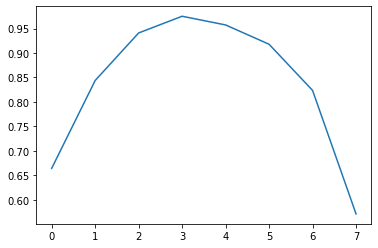

In [29]:
#align_evaluation_train_align_0.9_metric_hard_f1_align
plt.plot([0.7485, 0.8649, 0.9442, 0.9716, 0.9750, 0.9558, 0.9106, 0.7858, 0.2484])



In [17]:
l.train(nEpochs)

evaluation_dev_metric_hard_accuracy tensor(0.4901, device='cuda:0')
evaluation_dev_metric_hard_f1 tensor(0.1197, device='cuda:0')
evaluation_train_metric_hard_accuracy tensor(0.9339, device='cuda:0')
evaluation_train_metric_hard_f1 tensor(0.9658, device='cuda:0')
evaluation_human_metric_hard_accuracy tensor(0.9399, device='cuda:0')
evaluation_human_metric_hard_f1 tensor(0.9400, device='cuda:0')
evaluation_mouse_metric_hard_accuracy_1 tensor(0.9294, device='cuda:0')
evaluation_mouse_metric_hard_f1_1 tensor(0.9286, device='cuda:0')
evaluation_train_metric_pearson_r tensor(0., device='cuda:0')
evaluation_train_metric_spearman_r nan
evaluation_dev_metric_pearson_r tensor(-0.1513, device='cuda:0')
evaluation_dev_metric_spearman_r -0.19704398062584913
11293 tensor([0, 0, 0,  ..., 1, 0, 0], device='cuda:0')
tensor(0.2208, device='cuda:0')
evaluation_train_mean_reciprocal_rank tensor(0.2208, device='cuda:0')
1212 tensor([4, 1, 2,  ..., 1, 2, 1], device='cuda:0')
tensor(2.1205, device='cuda:0')

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6443, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7376, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5346, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6824, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3977, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4560, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3993, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5506, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8487, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8685, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7061, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6472, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7392, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5354, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6828, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4142, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4802, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4026, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5509, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8483, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8682, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7057, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6509, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7412, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5359, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6830, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4125, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4702, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4010, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5479, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8545, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8730, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7036, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6480, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7396, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5363, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6832, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3993, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4583, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4026, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5486, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8545, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8730, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7028, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6496, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7405, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5375, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6838, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4076, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4666, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4059, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5545, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8537, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8723, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7032, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6496, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7405, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5392, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6845, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4175, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4739, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4142, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5590, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8491, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8689, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7090, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6480, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7396, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5396, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6847, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4043, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4636, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4059, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5511, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8553, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8736, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7073, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6513, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7414, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5396, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6847, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4059, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4611, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4043, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5493, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8516, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8708, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7086, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6546, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7433, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5412, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6855, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4026, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4565, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4010, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5468, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8458, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8664, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7082, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6546, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7433, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5416, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6857, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4010, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4558, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4043, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5471, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8491, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8689, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7061, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6570, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7446, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5425, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6861, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4059, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4627, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4010, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5422, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8504, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8698, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7065, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6562, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7442, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5437, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6867, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3960, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4537, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4026, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5452, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8508, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8702, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7090, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6608, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7467, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5453, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6874, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3927, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4507, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.4026, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5452, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8450, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8658, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7086, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6624, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7476, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5429, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6863, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3911, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4549, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3960, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5367, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8479, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8680, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7065, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6649, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7490, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5462, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6878, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3960, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4586, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3944, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5360, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8487, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8686, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7065, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6645, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7488, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5491, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6892, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3911, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4517, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3944, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5372, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8454, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8661, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7053, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6653, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7492, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5491, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6892, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3927, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4540, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3993, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5416, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8442, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8652, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7040, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6649, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7490, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5511, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6902, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3927, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4588, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3861, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5327, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8442, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8652, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7049, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6649, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7490, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5507, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6900, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.3977, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4560, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3894, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5352, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8479, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8680, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7024, device='cuda:0')
a

align_evaluation_train_align_0.1_metric_hard_accuracy_align tensor(0.6641, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align tensor(0.7485, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_accuracy_align_mean tensor(0.5519, device='cuda:0')
align_evaluation_train_align_0.1_metric_hard_f1_align_mean tensor(0.6906, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align tensor(0.4010, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align tensor(0.4622, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_accuracy_align_mean tensor(0.3911, device='cuda:0')
align_evaluation_dev_align_0.1_metric_hard_f1_align_mean tensor(0.5335, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align tensor(0.8438, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_f1_align tensor(0.8649, device='cuda:0')
align_evaluation_train_align_0.2_metric_hard_accuracy_align_mean tensor(0.7032, device='cuda:0')
a

In [11]:
l.evaluation(threshold)

tensor([[  93, 3629],
        [3629,   93],
        [1379, 4595],
        ...,
        [ 438, 4767],
        [2505, 2873],
        [2873, 2505]], device='cuda:0')
tensor([[4744,  791],
        [ 791, 4744],
        [2450, 5960],
        ...,
        [2860,  464],
        [2676, 5717],
        [5717, 2676]], device='cuda:0')
tensor([[  93, 3629],
        [3629,   93],
        [1379, 4595],
        ...,
        [ 438, 4767],
        [2505, 2873],
        [2873, 2505]], device='cuda:0')
tensor([[4744,  791],
        [ 791, 4744],
        [2450, 5960],
        ...,
        [2860,  464],
        [2676, 5717],
        [5717, 2676]], device='cuda:0')
tensor([[  93, 3629],
        [3629,   93],
        [1379, 4595],
        ...,
        [ 438, 4767],
        [2505, 2873],
        [2873, 2505]], device='cuda:0')
tensor([[4744,  791],
        [ 791, 4744],
        [2450, 5960],
        ...,
        [2860,  464],
        [2676, 5717],
        [5717, 2676]], device='cuda:0')
tensor([[  93, 3629],


In [12]:
rec_col.train

,0.05*align_cond_kl_loss,human_cond_kl_loss,loss,metric_hard_accuracy,metric_hard_f1,metric_pearson_r,metric_spearman_r,mouse_cond_kl_loss
0.0,0.101246,2.052412,4.139367,0.001967,0.003926,0.0,NaN,1.985710
1.0,0.041757,0.725121,1.549436,0.423836,0.595344,0.0,NaN,0.782558
2.0,0.040762,0.652182,1.403351,0.464330,0.634188,0.0,NaN,0.710407
3.0,0.040892,0.609991,1.309038,0.479324,0.648032,0.0,NaN,0.658155
4.0,0.040200,0.568517,1.204336,0.507563,0.673355,0.0,NaN,0.595619
5.0,0.040206,0.538850,1.140987,0.514464,0.679401,0.0,NaN,0.561930
6.0,0.040884,0.511565,1.101887,0.510992,0.676367,0.0,NaN,0.549438
7.0,0.040745,0.506880,1.065870,0.507684,0.673462,0.0,NaN,0.518245
8.0,0.040098,0.481300,1.012023,0.526330,0.689668,0.0,NaN,0.490625
9.0,0.039787,0.468834,0.988309,0.534688,0.696804,0.0,NaN,0.479688


In [13]:
rec_col.dev

,0.05*align_cond_kl_loss,human_cond_kl_loss,loss,metric_hard_accuracy,metric_hard_f1,metric_pearson_r,metric_spearman_r,mouse_cond_kl_loss
0.0,0.054029,NaN,0.054029,0.499175,0.006547,0.044865,0.038203,NaN
1.0,0.058552,NaN,0.058552,0.503300,0.047468,0.020151,0.026879,NaN
2.0,0.062936,NaN,0.062936,0.502475,0.047393,0.010249,0.020059,NaN
3.0,0.066023,NaN,0.066023,0.498350,0.037975,-0.005482,0.021167,NaN
4.0,0.068025,NaN,0.068025,0.502475,0.044374,-0.002229,0.022615,NaN
5.0,0.069085,NaN,0.069085,0.494224,0.019200,-0.003918,0.024691,NaN
6.0,0.069291,NaN,0.069291,0.493399,0.022293,-0.009984,0.025327,NaN
7.0,0.069460,NaN,0.069460,0.495050,0.028571,-0.004255,0.017286,NaN
8.0,0.069263,NaN,0.069263,0.494224,0.019200,-0.003262,0.016409,NaN
9.0,0.068784,NaN,0.068784,0.495875,0.025518,0.002939,0.018088,NaN


In [14]:
rec_col.train_align

,metric_hard_accuracy_align,metric_hard_accuracy_align_mean,metric_hard_f1_align,metric_hard_f1_align_mean
0.1,0.537923,0.510305,0.458716,0.504174
0.2,0.518137,0.517725,0.239427,0.344905
0.3,0.506595,0.519373,0.107383,0.230871
0.4,0.501237,0.513603,0.044234,0.133627
0.5,0.500824,0.504122,0.017843,0.052009
0.6,0.499588,0.500412,0.004918,0.014634
0.7,0.499588,0.500412,NaN,0.003289
0.8,0.500000,0.500000,NaN,NaN
0.9,0.500000,0.500000,NaN,NaN


In [15]:
rec_col.dev_align

,metric_hard_accuracy_align,metric_hard_accuracy_align_mean,metric_hard_f1_align,metric_hard_f1_align_mean
0.1,0.50165,0.498350,0.405512,0.498350
0.2,0.50000,0.491749,0.212987,0.318584
0.3,0.49670,0.486799,0.072948,0.166220
0.4,0.49835,0.488449,0.037975,0.071856
0.5,0.49670,0.495050,0.006515,0.037736
0.6,0.49835,0.496700,NaN,NaN
0.7,0.50000,0.500000,NaN,NaN
0.8,0.50000,0.500000,NaN,NaN
0.9,0.50000,0.500000,NaN,NaN


In [16]:
# $$$$_1 refers to mouse, the metrics without a subscript _1, refer to the human ontology

rec_col.onto

,metric_hard_accuracy,metric_hard_accuracy_1,metric_hard_f1,metric_hard_f1_1
0,0.500000,0.500369,0.004049,0.004775
1,0.610918,0.627973,0.390355,0.436531
2,0.656649,0.669924,0.497770,0.530799
3,0.693235,0.712429,0.571139,0.612402
4,0.743031,0.748847,0.660399,0.675946
5,0.789634,0.775032,0.738306,0.718049
6,0.811411,0.800572,0.771101,0.757647
7,0.834930,0.819749,0.805208,0.785612
8,0.852497,0.834317,0.829244,0.805667
9,0.865563,0.850544,0.846841,0.827682


In [17]:
rec_col.bias

,pct_of_align_cond_on_human_as_min
0,0.513201


In [18]:
rec_col.probs

,Alignment 1 Probablity,Alignment 2 Probablity,Minimum Probablity
0,0.207232,0.173863,0.173863
1,0.035018,0.040546,0.035018
2,0.013036,0.011273,0.011273
3,0.192903,0.723837,0.192903
4,0.111053,0.090839,0.090839
...,...,...,...
601,0.474985,0.020003,0.020003
602,0.192557,0.137757,0.137757
603,0.100501,0.083605,0.083605
604,0.016698,0.371385,0.016698


## Make plots

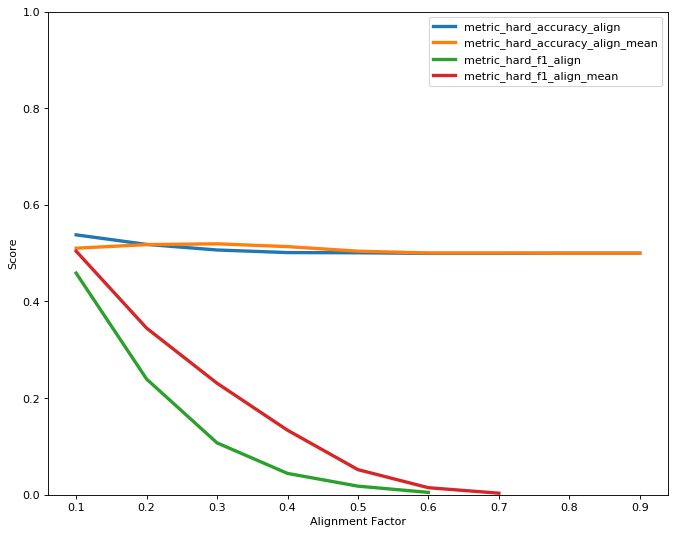

In [19]:
df_train = rec_col.train_align.dataframe

fig1 = plt.figure(num=1, figsize=(10,8), dpi=80, facecolor='white')
plt.plot(df_train, linewidth=3)
plt.ylim((0,1))
plt.xlabel("Alignment Factor")
plt.ylabel("Score")
plt.legend(df_train, loc=0)

# plt.show()

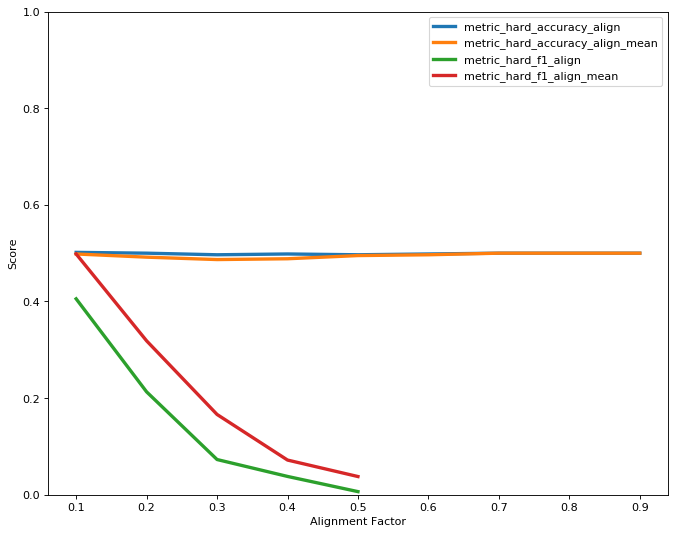

In [20]:
df_dev = rec_col.dev_align.dataframe

fig2 = plt.figure(num=2, figsize=(10,8), dpi=80, facecolor='white')
plt.plot(df_dev, linewidth=3)
plt.ylim((0,1))
plt.xlabel("Alignment Factor")
plt.ylabel("Score")
plt.legend(df_train, loc=0)

# plt.show()

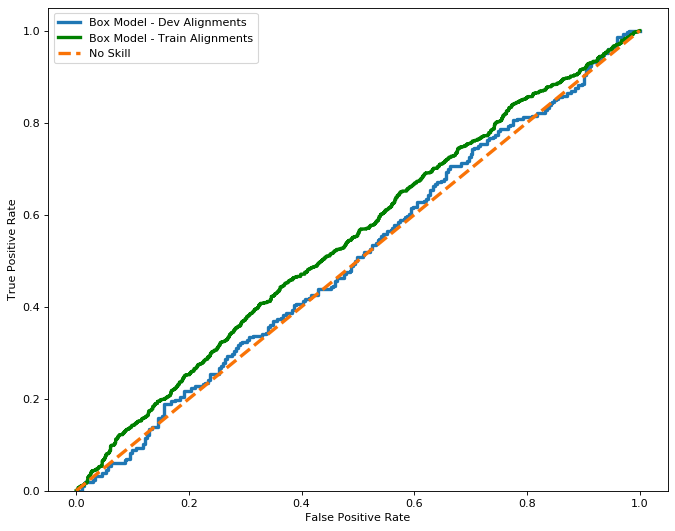

In [21]:
fig3 = plt.figure(num=3, figsize=(10,8), dpi=80, facecolor='white')
plt.plot(rec_col.dev_roc_plot.dataframe['fpr'], rec_col.dev_roc_plot.dataframe['tpr'], linewidth=3)
plt.plot(rec_col.tr_roc_plot.dataframe['fpr'], rec_col.tr_roc_plot.dataframe['tpr'], color='g', linewidth=3)
plt.plot([0, 1], [0, 1], linestyle='--', color='xkcd:orange', linewidth=3)
plt.ylim((0,1.05))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(("Box Model - Dev Alignments", "Box Model - Train Alignments", "No Skill"), loc=0)

# plt.show()

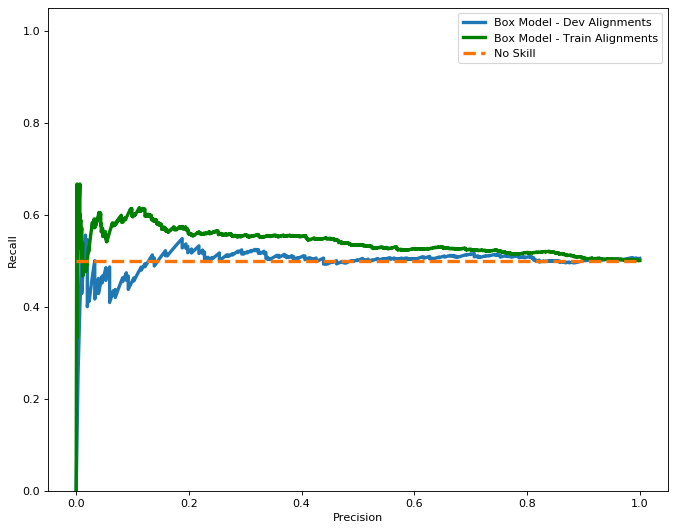

In [22]:
no_skill_pr = dev.probs[dev.probs==1].float().sum()  / dev.probs.shape[0]

fig4 = plt.figure(num=4, figsize=(10,8), dpi=80, facecolor='white')
plt.plot(rec_col.dev_pr_plot.dataframe['recall'], rec_col.dev_pr_plot.dataframe['precision'], linewidth=3)
plt.plot(rec_col.tr_pr_plot.dataframe['recall'], rec_col.tr_pr_plot.dataframe['precision'], color='g', linewidth=3)
plt.plot([0, 1], [no_skill_pr, no_skill_pr], linestyle='--', color='xkcd:orange', linewidth=3)
plt.ylim((0,1.05))
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(("Box Model - Dev Alignments", "Box Model - Train Alignments", "No Skill"), loc=0)

# plt.show()

(606,)


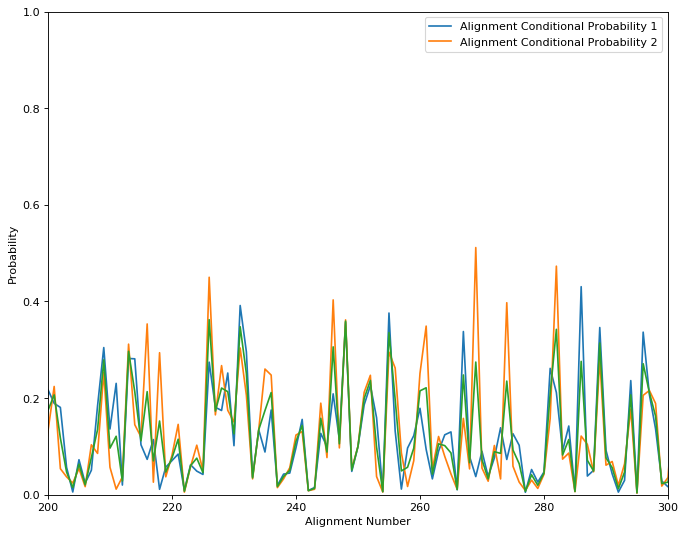

In [23]:
average_min_probability = np.mean(rec_col.probs.dataframe['Minimum Probablity'])
align_pair_probs = np.stack((rec_col.probs.dataframe['Alignment 1 Probablity'], 
                             rec_col.probs.dataframe['Alignment 2 Probablity']), axis=1)

average_align_pair_probs = np.mean(align_pair_probs, axis=1)
print(average_align_pair_probs.shape)

fig = plt.figure(figsize=(10,8), dpi=80, facecolor='white')
plt.plot(range(0, 606), rec_col.probs.dataframe['Alignment 1 Probablity'])
plt.plot(range(0, 606), rec_col.probs.dataframe['Alignment 2 Probablity'])
plt.plot(range(0, 606), average_align_pair_probs)
# plt.plot(range(0, 606), rec_col.probs.dataframe['Minimum Probablity'])
# plt.plot([0, 606], [average_min_probability, average_min_probability], linestyle='--')
plt.ylim((0,1))
plt.xlim((200,300))
plt.xlabel("Alignment Number")
plt.ylabel("Probability")
plt.legend(("Alignment Conditional Probability 1", 
            "Alignment Conditional Probability 2", 
# #             "Minimum Probability", "Average Minimum Probability"
           ), loc=0)

# plt.show()


In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(box_model)

120741

### Save the model

In [47]:
fpath =  f"../results/{box_type.__name__}_nEpochs{nEpochs}_lr{lr}_dims{dims}_ratio{rns_ratio}_{tc}split{ats}_Unary{use_unary}{unary_weight}/"

# This is the most naive implementation
def save_recorders():
    rec_col.learn.dataframe.to_csv(f"{fpath}learn.csv")
    rec_col.train.dataframe.to_csv(f"{fpath}train.csv")
    rec_col.dev.dataframe.to_csv(f"{fpath}dev.csv")
    rec_col.onto.dataframe.to_csv(f"{fpath}onto.csv")
    rec_col.train_align.dataframe.to_csv(f"{fpath}train_align.csv")
    rec_col.dev_align.dataframe.to_csv(f"{fpath}dev_align.csv")
    rec_col.dev_roc_plot.dataframe.to_csv(f"{fpath}dev_roc_plot.csv")
    rec_col.dev_pr_plot.dataframe.to_csv(f"{fpath}dev_pr_plot.csv")
    rec_col.tr_roc_plot.dataframe.to_csv(f"{fpath}tr_roc_plot.csv")
    rec_col.tr_pr_plot.dataframe.to_csv(f"{fpath}tr_pr_plot.csv")
    rec_col.probs.dataframe.to_csv(f"{fpath}probs.csv")
    rec_col.bias.dataframe.to_csv(f"{fpath}bias.csv")
    
def save_plots():
    fig1.savefig(f"{fpath}train_alignment_plot.png")
    fig2.savefig(f"{fpath}dev_alignment_plot.png")
    fig3.savefig(f"{fpath}roc_curve.png")
    fig4.savefig(f"{fpath}pr_curve.png")


try:
    os.makedirs(fpath)
except OSError:
    print("Creation of the directory %s failed" % fpath)
    print("Did not save any of the files.")
else:
    print("Successfully created the directory %s " % fpath)
    print("Saving files ...")
    
    fmodel = f"{fpath}model.pth"
    
    save_model = {}
    save_model['state_dict'] = box_model.state_dict()
    save_model['optimizer']  = opt.state_dict()
    save_model['nEpochs']  = nEpochs
    save_model['recorders'] = rec_col
    save_model['train'] = train
    save_model['tr_align'] = tr_align
    save_model['dev'] = dev
    torch.save(save_model, fmodel)
    
    save_recorders()
    save_plots()
    
    print("Save complete")

Successfully created the directory ../results/MinMaxSigmoidBoxes_nEpochs50_lr0.01_dims10_ratio1_split0.8_UnaryFalse0.01/ 
Saving files ...
Save complete
